In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import Dataset, DataLoader
import pickle
from script.util import create_graph, subgraph_dijkstra, LSTMModel, TimeSeriesDataset, my_data_loader,ExpSmooth
from script.fedutil import local_dataset,fed_training_plan
import matplotlib.pyplot as plt
import networkx as nx
from script.metrics import rmse,rmspe, maape


In [45]:
flow_file= "./data/PEMS04/pems04.npz"
csv_file = "./data/PEMS04/distance.csv"

data = np.load(flow_file)
df = pd.read_csv(csv_file)
TS = data['data']
flow = TS[:,:,0]

# flow dict 100 time series is the sensor number and the value the traffic flow times serie
flow_dict={k:flow[:,k] for k in range(307)}

# list of the first 10 connected sensor, each sensor traffic flow is contained in PeMS 
PeMS = pd.DataFrame(flow_dict)

In [46]:
# time serie of sensor k
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)
PeMS = PeMS.set_index(index)

In [47]:
PeMS[118] 

2018-01-01 00:00:00     79.0
2018-01-01 00:05:00     29.0
2018-01-01 00:10:00      0.0
2018-01-01 00:15:00     10.0
2018-01-01 00:20:00      0.0
                       ...  
2018-02-28 23:35:00    112.0
2018-02-28 23:40:00    132.0
2018-02-28 23:45:00    120.0
2018-02-28 23:50:00     99.0
2018-02-28 23:55:00    114.0
Freq: 5T, Name: 118, Length: 16992, dtype: float64

In [48]:
PeMS[261]

2018-01-01 00:00:00    73.0
2018-01-01 00:05:00    69.0
2018-01-01 00:10:00    66.0
2018-01-01 00:15:00    63.0
2018-01-01 00:20:00    60.0
                       ... 
2018-02-28 23:35:00    86.0
2018-02-28 23:40:00    86.0
2018-02-28 23:45:00    80.0
2018-02-28 23:50:00    73.0
2018-02-28 23:55:00    65.0
Freq: 5T, Name: 261, Length: 16992, dtype: float64

In [49]:
PeMS[169]

2018-01-01 00:00:00    73.0
2018-01-01 00:05:00    69.0
2018-01-01 00:10:00    66.0
2018-01-01 00:15:00    63.0
2018-01-01 00:20:00    60.0
                       ... 
2018-02-28 23:35:00    86.0
2018-02-28 23:40:00    86.0
2018-02-28 23:45:00    80.0
2018-02-28 23:50:00    73.0
2018-02-28 23:55:00    65.0
Freq: 5T, Name: 169, Length: 16992, dtype: float64

In [50]:
G = create_graph(df)

In [51]:
subgraph = subgraph_dijkstra(G,0,99)

In [52]:
PeMS = PeMS[list(subgraph.nodes)]

#Sort time series by mean traffic flow
mean_flow = PeMS.mean().sort_values()
#Index of sensor sort by mean traffic flow
mean_flow_index = mean_flow.index


column_order = list(mean_flow_index)
PeMS =PeMS.reindex(columns=column_order)

In [53]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:47] + column_order[48:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 170, 169, 168]


In [54]:
for i in goodnodes:
    print("Nodes {} with mean traffic flow : {}".format(i,mean_flow[i]))

Nodes 118 with mean traffic flow : 236.87270480225988
Nodes 261 with mean traffic flow : 240.57203389830508
Nodes 179 with mean traffic flow : 240.57203389830508
Nodes 170 with mean traffic flow : 240.57203389830508
Nodes 169 with mean traffic flow : 240.57203389830508
Nodes 168 with mean traffic flow : 242.85905131826743


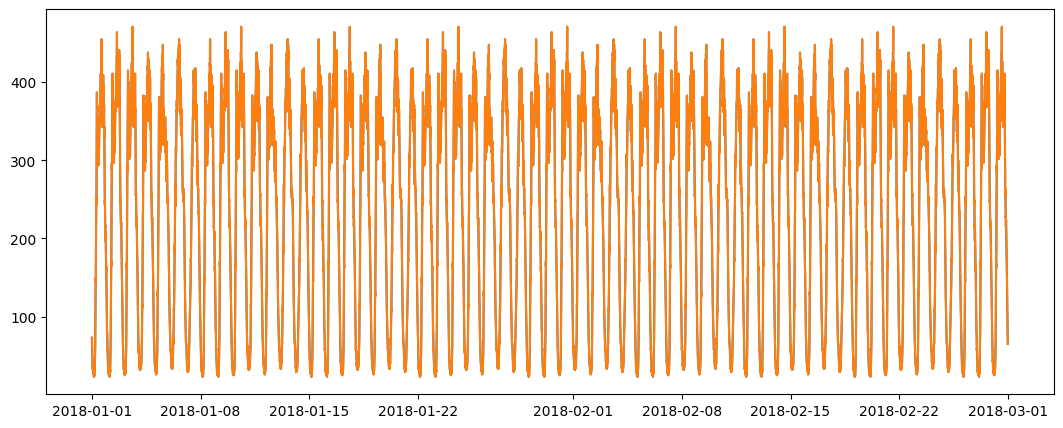

In [55]:
plt.figure(figsize=(13, 5))
plt.plot(PeMS[261])
plt.plot(PeMS[169])

In [56]:
node_colors ={node: 'red' if node in goodnodes else 'blue' for node in G.nodes}


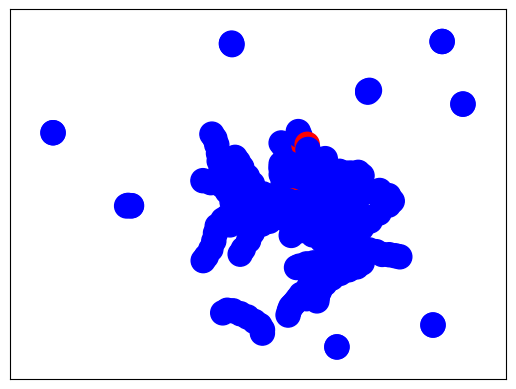

In [57]:
nx.draw_networkx(G, with_labels=False, node_color=[node_colors[node] for node in G.nodes()])

In [58]:
duplicate=PeMS.T.duplicated()

In [59]:
print(PeMS.columns[duplicate])

Index([181, 179, 177, 170, 169], dtype='int64')


In [63]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 177, 170, 169, 168]


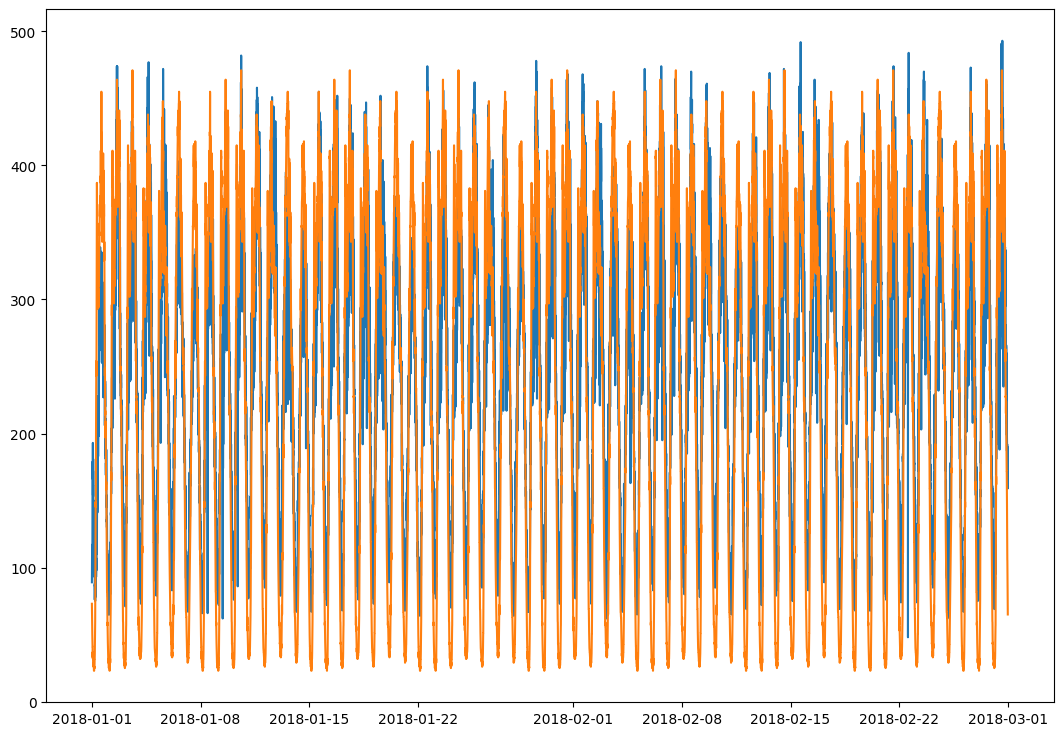

In [64]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[168])
plt.plot(PeMS[261])

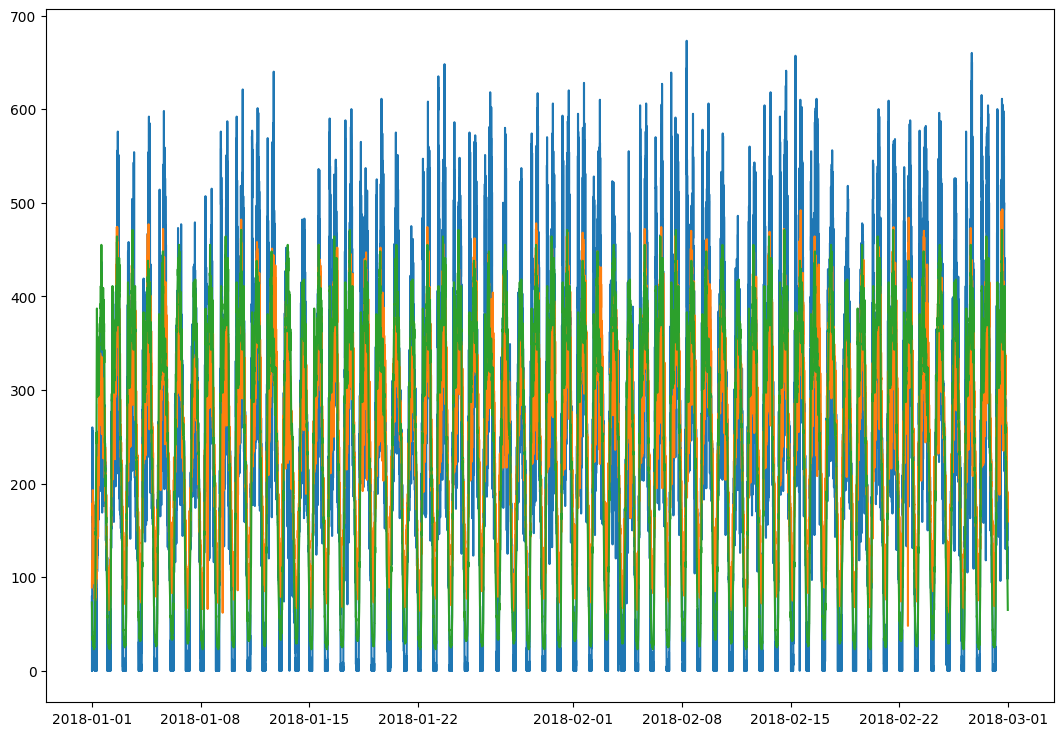

In [65]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[118])
plt.plot(PeMS[168])
plt.plot(PeMS[261])

In [66]:
fedPeMS = PeMS[[118,168,261]]

In [68]:
# Smoot DataFrame
df = ExpSmooth(fedPeMS,3)

c:\Users\mbenali\Desktop\Federated-Traffic-Flow-Forecasting\script\util.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns[i]] = smoothed_values


In [70]:
def center_reduce(df):
    dict={}
    for column in df.columns:
        colmean = df[column].mean()
        colstd = df[column].std()
        df[column] = df[column]-colmean
        df[column] = df[column]/colstd
        dict[column] = {'mean':colmean,'std':colstd}
    return df, dict

In [ ]:
def uncenter_unreduce(df,dict):
    for column in df.columns:
        df[column] = df[column]*dict[column]['std']
        df[column] = df[column]+dict[column]['mean'] 
    return df

In [71]:
newdf, dict =center_reduce(df)

C:\Users\mbenali\AppData\Local\Temp\ipykernel_6060\981444403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]-colmean
C:\Users\mbenali\AppData\Local\Temp\ipykernel_6060\981444403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]/colstd


In [78]:
y_true

array([-1.52970147, -1.52977365, -1.52404582, ..., -1.04488674,
       -1.07828044, -1.11656658])

In [75]:
main_model = LSTMModel(input_size=1,output_size=1)

In [74]:
datadict= local_dataset(newdf,3,len(df))

In [76]:
fed_training_plan(datadict,rounds=50,epoch=50)

INIT ROUND 1 :
Training node 0 for round 1
Epoch 1/50, Training Loss: 118.5682, Validation Loss: 0.0664
Epoch 2/50, Training Loss: 20.9351, Validation Loss: 0.0548
Epoch 3/50, Training Loss: 16.9476, Validation Loss: 0.1997
Epoch 4/50, Training Loss: 13.7048, Validation Loss: 0.1234
Epoch 5/50, Training Loss: 10.7071, Validation Loss: 0.0138
Epoch 6/50, Training Loss: 6.1569, Validation Loss: 0.0334
Epoch 7/50, Training Loss: 4.6527, Validation Loss: 0.0288
Epoch 8/50, Training Loss: 4.4174, Validation Loss: 0.0299
Epoch 9/50, Training Loss: 3.8156, Validation Loss: 0.0257
Epoch 10/50, Training Loss: 4.6500, Validation Loss: 0.0143
Epoch 11/50, Training Loss: 3.4012, Validation Loss: 0.0147
Epoch 12/50, Training Loss: 3.7774, Validation Loss: 0.0347
Epoch 13/50, Training Loss: 4.0308, Validation Loss: 0.0265
Epoch 14/50, Training Loss: 3.7928, Validation Loss: 0.0167
Epoch 15/50, Training Loss: 3.4544, Validation Loss: 0.0156
Epoch 16/50, Training Loss: 3.0837, Validation Loss: 0.0104


In [82]:
dict

{118: {'mean': 236.86296221006594, 'std': 149.88423666202848},
 168: {'mean': 242.83818140738057, 'std': 99.08987996156547},
 261: {'mean': 240.56893219996417, 'std': 138.274708369788}}

In [83]:
mylist = [118,168,261]

In [87]:
criterion = torch.nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for j in range(3):
    print('Round {}'.format(j))
    for k in range(1,51):
        print("Results for node {} ROUND {} : ".format(j,k))
        best_model = LSTMModel(input_size=1, hidden_size=32, num_layers=6, output_size=1).to(device)
        best_model.load_state_dict(torch.load('model_round_'+str(k)+'.pth'))
        best_model.double()
        best_model.eval()
        test_loader= datadict[j]['test']
        test_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                x = torch.Tensor(inputs).unsqueeze(1).to(device)
                y = torch.Tensor(targets).unsqueeze(0).to(device)
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())
        test_loss /= len(test_loader)
        print(f"Test MSE Loss: {test_loss:.4f}")
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        test_data = datadict[j]['test_data']
        window_size = 7
        EPSILON = 1e-10
        i=k
        #plt.figure(figsize=(28, 5))
        #plt.title('Actual vs Prediction of sensor N° {}'.format(j))
        y_pred = predictions[:,0]*dict[mylist[j]]['std']+dict[mylist[j]]['mean']
        y_true = actuals[:,0]*dict[mylist[j]]['std']+dict[mylist[j]]['mean']
        #plt.plot(test_data.index[window_size:],y_true, label='Actuals')
        #plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
        rmse_val= rmse(y_true,y_pred)
        rmspe_val = rmspe(y_true,y_pred)
        maape_val =  maape(y_true,y_pred)
        # Add evaluation metrics to the plot
        #plt.annotate(f'RMSE: {rmspe_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
        #plt.annotate(f'RMSPE: {rmspe_val:.2f}', xy=(0.005, 0.55), xycoords='axes fraction')
        #plt.annotate(f'MAAPE: {maape_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
        # Set x and y labels
        #plt.xlabel('Time')
        #plt.ylabel('Value')
        #plt.legend()
        print(f"RMSE: {rmse_val:.3f}, RMSPE: {rmspe_val:.3f} % , MAAPE: {maape_val:.3f} %")
        #plt.show()
    print(' ')

Round 0
Results for node 0 ROUND 1 : 
Test MSE Loss: 0.0194
RMSE: 20.944, RMSPE: 1306.345 % , MAAPE: 25.562 %
Results for node 0 ROUND 2 : 
Test MSE Loss: 0.0074
RMSE: 12.898, RMSPE: 352.079 % , MAAPE: 19.016 %
Results for node 0 ROUND 3 : 
Test MSE Loss: 0.0066
RMSE: 12.239, RMSPE: 270.311 % , MAAPE: 16.959 %
Results for node 0 ROUND 4 : 
Test MSE Loss: 0.0066
RMSE: 12.173, RMSPE: 159.462 % , MAAPE: 14.695 %
Results for node 0 ROUND 5 : 
Test MSE Loss: 0.0065
RMSE: 12.162, RMSPE: 117.184 % , MAAPE: 12.855 %
Results for node 0 ROUND 6 : 
Test MSE Loss: 0.0065
RMSE: 12.089, RMSPE: 66.966 % , MAAPE: 10.091 %
Results for node 0 ROUND 7 : 
Test MSE Loss: 0.0066
RMSE: 12.214, RMSPE: 106.440 % , MAAPE: 12.720 %
Results for node 0 ROUND 8 : 
Test MSE Loss: 0.0066
RMSE: 12.198, RMSPE: 60.875 % , MAAPE: 11.024 %
Results for node 0 ROUND 9 : 
Test MSE Loss: 0.0066
RMSE: 12.237, RMSPE: 26.029 % , MAAPE: 8.191 %
Results for node 0 ROUND 10 : 
Test MSE Loss: 0.0067
RMSE: 12.269, RMSPE: 31.858 % , M

In [24]:
datadict[0].keys()

dict_keys(['train', 'val', 'test', 'test_data'])

In [25]:
from src.models import LSTMModel, train_model
for j in range(3):
    new_model = LSTMModel(1,32,1)
    data_dict = datadict[j]
    train_model(new_model, data_dict['train'], data_dict['val'], model_path ='./local{}.pth'.format(j) )

Epoch 1/200, Training Loss: 26948448.1187, Validation Loss: 73661.4331
Epoch 2/200, Training Loss: 25094938.9030, Validation Loss: 69070.5855
Epoch 3/200, Training Loss: 23520992.5694, Validation Loss: 64778.9778
Epoch 4/200, Training Loss: 21999176.0921, Validation Loss: 60680.0120
Epoch 5/200, Training Loss: 20580850.8640, Validation Loss: 56848.1685
Epoch 6/200, Training Loss: 19249567.1760, Validation Loss: 53233.0509
Epoch 7/200, Training Loss: 17993658.0506, Validation Loss: 49808.0953
Epoch 8/200, Training Loss: 16809328.0612, Validation Loss: 46579.8186
Epoch 9/200, Training Loss: 15688270.9179, Validation Loss: 43517.2658
Epoch 10/200, Training Loss: 14631114.3073, Validation Loss: 40626.7401
Epoch 11/200, Training Loss: 13634088.3691, Validation Loss: 37895.6180
Epoch 12/200, Training Loss: 12692967.9374, Validation Loss: 35316.5538
Epoch 13/200, Training Loss: 11805507.4292, Validation Loss: 32882.5976
Epoch 14/200, Training Loss: 10971797.7270, Validation Loss: 30588.6300
E

In [27]:
datadict[0].keys()

dict_keys(['train', 'val', 'test', 'test_data'])

In [28]:
def testmodel(datadict, best_model=LSTMModel(input_size=1, hidden_size=32, num_layers=6, output_size=1) , path='local.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model.load_state_dict(torch.load(path))
    best_model = best_model.to(device)
    criterion = torch.nn.MSELoss()
    best_model.double()
    best_model.eval()
    test_loader= datadict['test']
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            x = torch.Tensor(inputs).unsqueeze(1).to(device)
            y = torch.Tensor(targets).unsqueeze(0).to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test MSE Loss: {test_loss:.4f}")
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    test_data = datadict['test_data']
    window_size = 7
    EPSILON = 1e-10
    plt.figure(figsize=(28, 5))
    plt.title('Actual vs Prediction')
    y_pred = predictions[:,0]
    y_true = actuals[:,0]
    plt.plot(test_data.index[window_size:],y_true, label='Actuals')
    plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
    rmse_val= rmse(y_true,y_pred)
    rmspe_val = rmspe(y_true,y_pred)
    maape_val =  maape(y_true,y_pred)
    # Add evaluation metrics to the plot
    plt.annotate(f'RMSE: {rmspe_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
    plt.annotate(f'RMSPE: {rmspe_val:.2f}', xy=(0.005, 0.55), xycoords='axes fraction')
    plt.annotate(f'MAAPE: {maape_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
    # Set x and y labels
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    print(f"RMSE:{rmse_val:.3f}, RMSPE:{rmspe_val:.3f} % , MAAPE:{maape_val:.3f} %")
    plt.show()


la jolie {i}


Test MSE Loss: 144.9174
RMSE:12.075, RMSPE:117.421 % , MAAPE:12.339 %


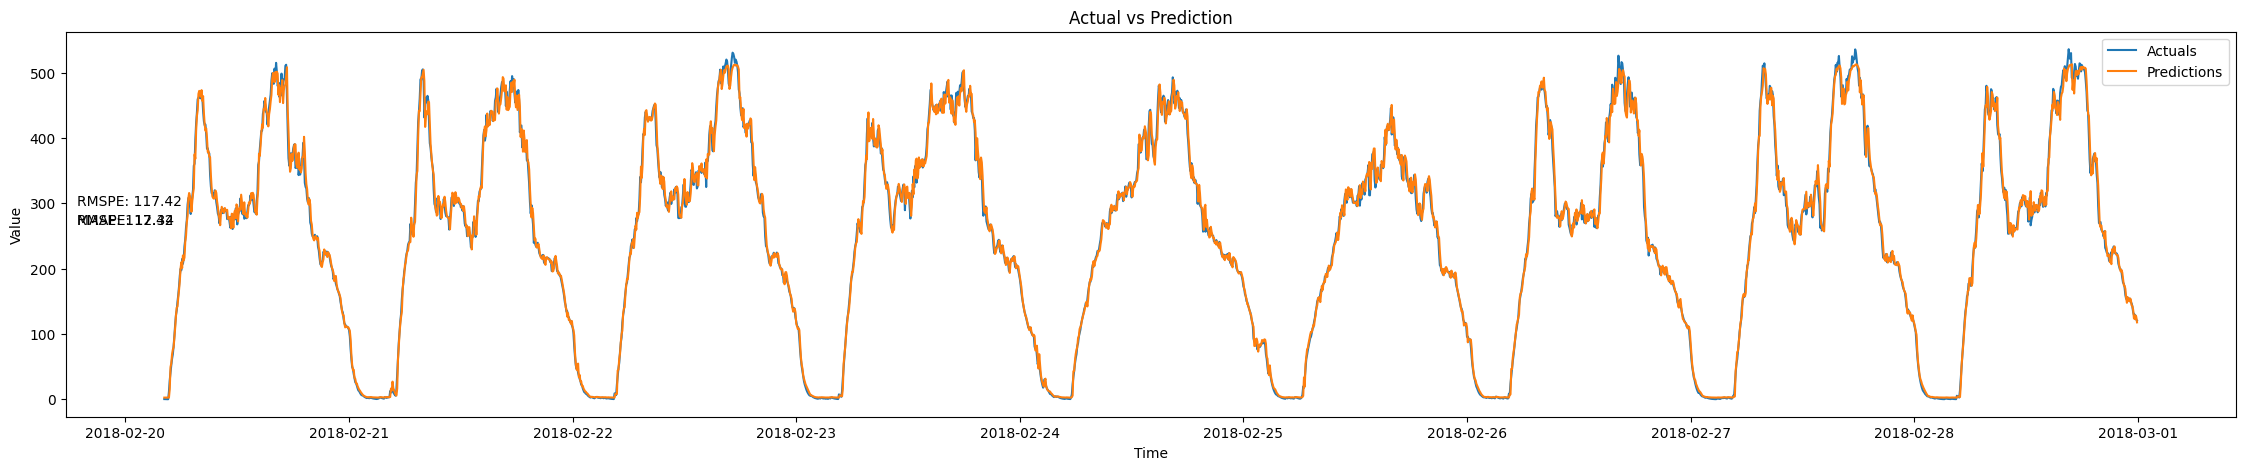

Test MSE Loss: 35.6004
RMSE:5.982, RMSPE:2.329 % , MAAPE:1.735 %


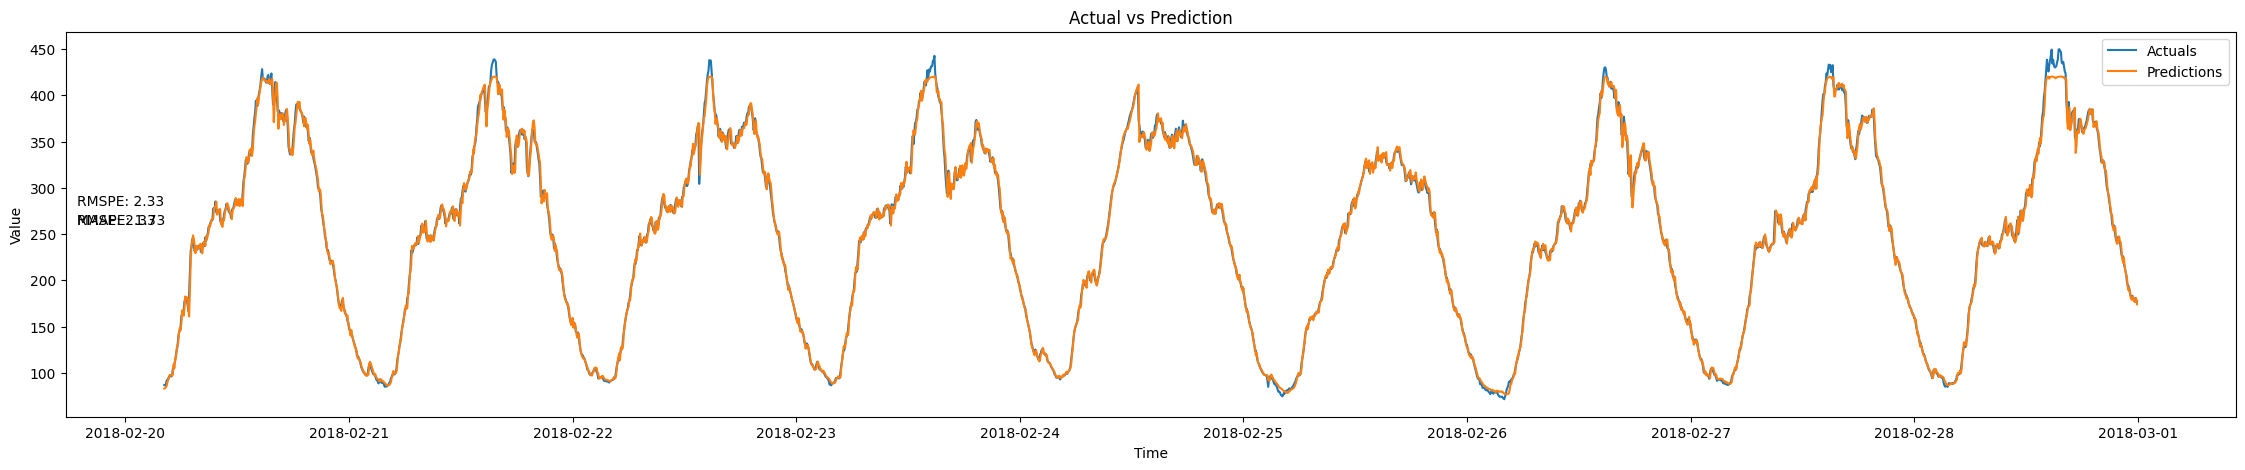

Test MSE Loss: 5.9980
RMSE:2.455, RMSPE:1.145 % , MAAPE:0.820 %


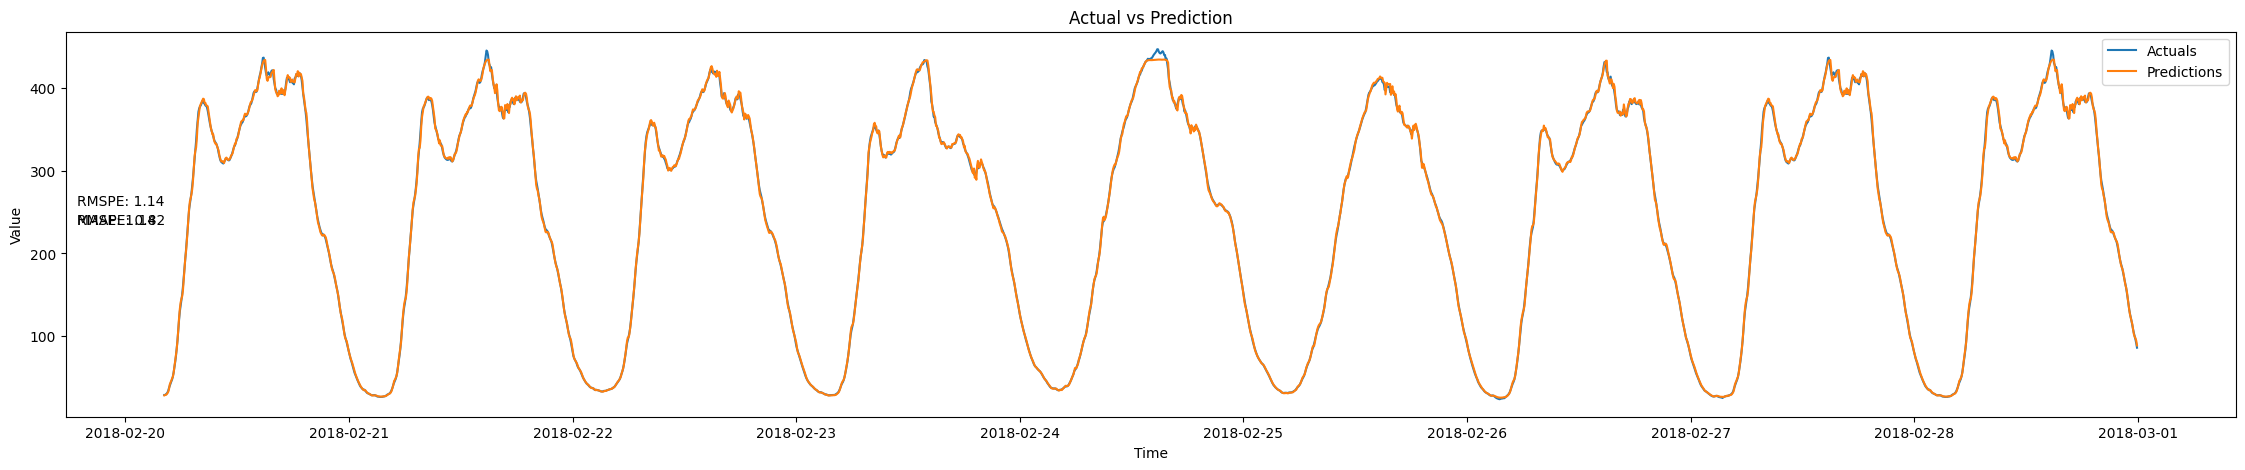

In [29]:
for i in range(3):
    testmodel(datadict[i], path= './local{}.pth'.format(i))

In [ ]:
2.455

In [ ]:
criterion = torch.nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for j in range(3): 
    for k in range(1,11):
        print("Results for node {} ROUND {} : ".format(i,k))
        best_model = LSTMModel(input_size=1, hidden_size=32, num_layers=6, output_size=1).to(device)
        best_model.load_state_dict(torch.load('model_round_'+str(k)+'.pth'))
        best_model.double()
        best_model.eval()
        test_loader= datadict[j]['test']
        test_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                x = torch.Tensor(inputs).unsqueeze(1).to(device)
                y = torch.Tensor(targets).unsqueeze(0).to(device)
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())
        test_loss /= len(test_loader)
        print(f"Test MSE Loss: {test_loss:.4f}")
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        test_data = datadict[j]['test_data']
        window_size = 7
        EPSILON = 1e-10
        i=k
        plt.figure(figsize=(28, 5))
        plt.title('Actual vs Prediction of sensor N° {}'.format(j))
        y_pred = predictions[:,0]
        y_true = actuals[:,0]
        plt.plot(test_data.index[window_size:],y_true, label='Actuals')
        plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
        rmse_val= rmse(y_true,y_pred)
        rmspe_val = rmspe(y_true,y_pred)
        maape_val =  maape(y_true,y_pred)
        # Add evaluation metrics to the plot
        plt.annotate(f'RMSE: {rmspe_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
        plt.annotate(f'RMSPE: {rmspe_val:.2f}', xy=(0.005, 0.55), xycoords='axes fraction')
        plt.annotate(f'MAAPE: {maape_val:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
        # Set x and y labels
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        print(f"RMSE:{rmse_val:.3f}, RMSPE:{rmspe_val:.3f} % , MAAPE:{maape_val:.3f} %")
        plt.show()


In [90]:
2.328*1.054553264604811

2.455

In [93]:
5.611/5.982

0.937980608492143